In [286]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd

print("TF version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TF version:  2.5.0
Keras version:  2.5.0


In [287]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_dev, y_dev) = mnist.load_data()

In [288]:
rescale = keras.Sequential([layers.experimental.preprocessing.Rescaling(1.0/255)])

In [289]:
X_train = tf.reshape(rescale(X_train), shape=(-1, 28, 28, 1))
X_dev = tf.reshape(rescale(X_dev), shape=(-1, 28, 28, 1))

In [290]:
X_train.shape, X_dev.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [291]:
transformations = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.01),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom((-0.1, 0.1))
])
X_train_transformed = transformations(X_train)
X_dev_transformed = transformations(X_dev)

In [292]:
def plot_img(img: np.array, label: int):
    print('Number:', label)
    plt.imshow(img.squeeze(), cmap='gray')

Number: 9


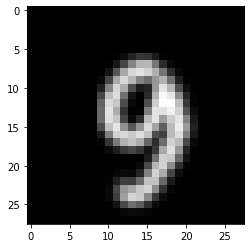

In [293]:
n = np.random.randint(X_train_transformed.shape[0])
plot_img(X_train_transformed[n].numpy(), y_train[n])

In [294]:
model = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [295]:
hist = model.fit(X_train_transformed, y_train,
    batch_size=32, epochs=15,
    validation_data=(X_dev_transformed, y_dev)
)

Epoch 1/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3285 - accuracy: 0.8960 - val_loss: 0.0808 - val_accuracy: 0.9770
Epoch 2/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1232 - accuracy: 0.9615 - val_loss: 0.0653 - val_accuracy: 0.9793
Epoch 3/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0916 - accuracy: 0.9714 - val_loss: 0.0512 - val_accuracy: 0.9837
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0773 - accuracy: 0.9751 - val_loss: 0.0402 - val_accuracy: 0.9870
Epoch 5/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0685 - accuracy: 0.9784 - val_loss: 0.0472 - val_accuracy: 0.9860
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0582 - accuracy: 0.9810 - val_loss: 0.0434 - val_accuracy: 0.9854
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0535 - accuracy: 0.9833 - val_loss: 0.0359 - val_accur

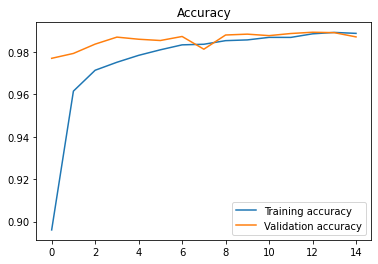

In [296]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

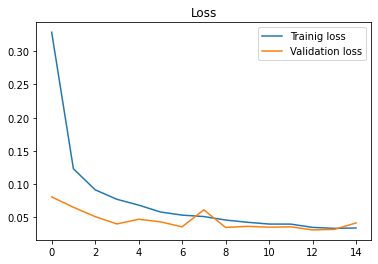

In [297]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

In [298]:
p_dev = np.argmax(model.predict(X_dev), axis=1)
p_train = np.argmax(model.predict(X_train), axis=1)

In [299]:
print("DEV F1 SCORE: ", f1_score(y_dev, p_dev, average='weighted'))
print("TRAIN F1 SCORE: ", f1_score(y_train, p_train, average='weighted'))

DEV F1 SCORE:  0.9902992677233404
TRAIN F1 SCORE:  0.9924368160644522


In [300]:
print("DEV CONFUSION MATRIX:")
pd.DataFrame(confusion_matrix(y_dev, p_dev))

DEV CONFUSION MATRIX:


,0,1,2,3,4,5,6,7,8,9
0,978,0,0,0,0,0,1,0,0,1
1,8,1126,0,0,0,0,0,1,0,0
2,0,3,1024,0,0,0,1,4,0,0
3,0,1,1,1003,0,1,0,1,0,3
4,0,0,0,0,973,0,1,0,1,7
5,0,0,0,7,0,880,1,2,0,2
6,3,4,0,0,2,3,943,0,3,0
7,0,4,11,1,0,0,0,1010,0,2
8,2,1,1,1,0,1,0,0,966,2
9,0,1,0,0,3,1,0,3,1,1000


**TODO:**   
1. anomaly detection / outlier removal
2. Retrain the net with better data
3. test the network with external data
4. if succesful save the net and load in the web app, else repeat the steps again

In [301]:
p_train_logits = model.predict(X_train)

In [302]:
def clean_dataset(X, y, y_pred_logits, clean_percent: float = 0.1):
    N_TO_REMOVE = round(X.shape[0] * clean_percent)
    max_accuracies_array = np.array(y_pred_logits.max(axis=1))
    X_ = X.tolist()
    y_ = y.tolist()
    all_concat = list(zip(X_, y_, max_accuracies_array.tolist()))
    all_concat.sort(key=lambda x: x[2])
    X_new, y_new, _ = zip(*all_concat[N_TO_REMOVE:])
    return np.array(X_new), np.array(y_new)

In [303]:
X_train_clean, y_train_clean = clean_dataset(X_train.numpy(), y_train, p_train_logits, 0.05)
X_train_clean.shape, y_train_clean.shape

((57000, 28, 28, 1), (57000,))

In [304]:
X_train_clean_transformed = transformations(X_train_clean)

Number: 3


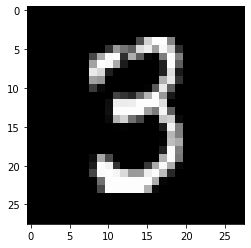

In [305]:
plot_img(X_train_clean[n], y_train_clean[n])

In [306]:
model2 = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)             

In [308]:
hist2 = model2.fit(X_train_clean_transformed, y_train_clean, 
                   batch_size=32, epochs=15, validation_data=(X_dev_transformed, y_dev))

Epoch 1/15
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0284 - accuracy: 0.9906 - val_loss: 0.0423 - val_accuracy: 0.9872
Epoch 2/15
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0268 - accuracy: 0.9916 - val_loss: 0.0433 - val_accuracy: 0.9863
Epoch 3/15
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.0510 - val_accuracy: 0.9856
Epoch 4/15
1782/1782 [==============================] - 10s 5ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0475 - val_accuracy: 0.9861
Epoch 5/15
1782/1782 [==============================] - 10s 5ms/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.0428 - val_accuracy: 0.9874
Epoch 6/15
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0208 - accuracy: 0.9935 - val_loss: 0.0378 - val_accuracy: 0.9886
Epoch 7/15
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0386 - val_accurac

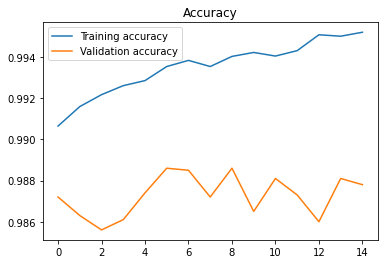

In [309]:
plt.title('Accuracy')
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

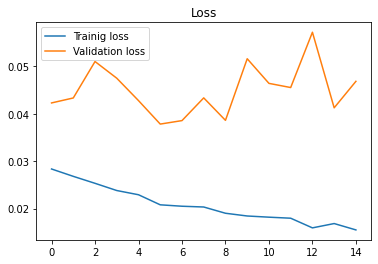

In [310]:
plt.title('Loss')
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

## Comparando os modelos

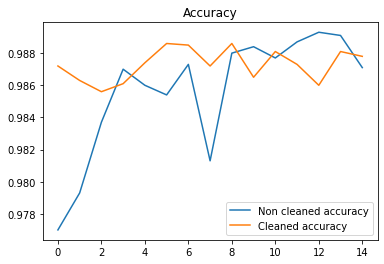

In [311]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Non cleaned accuracy', 'Cleaned accuracy'])
plt.show();

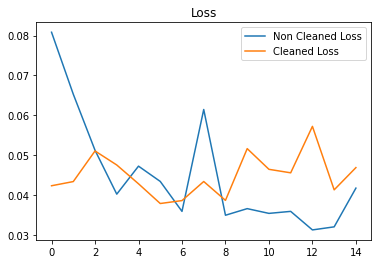

In [312]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['val_loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Non Cleaned Loss', 'Cleaned Loss'])
plt.show();

In [313]:
print("Non cleaned F1 Score:", f1_score(y_dev, np.argmax(model.predict(X_dev), axis=1), average='weighted'))
print("Cleaned F1 Score:", f1_score(y_dev, np.argmax(model2.predict(X_dev), axis=1), average='weighted'))

Non cleaned F1 Score: 0.9902992677233404
Cleaned F1 Score: 0.9905859069249902


### Analysing  the results

Apparently, the model trained with the cleaned data seems to be working worse than the first one, but if we pay attention to the fact that the dev data was not cleaned although it was used for validating the model trained with the cleaned data, so in real data, the results may be different.

In [314]:
one = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16326458752155304, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0.5714263319969177, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285658299922943, 1, 1, 0.4897943437099457, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24489717185497284, 1, 1, 1, 0, 1, 1, 0.14286039769649506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9996798634529114, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20408114790916443, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4285736083984375, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9983993172645569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.5918376445770264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.28571316599845886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9990395307540894, 0.7543814182281494, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], shape=(1, 28, 28, 1))

Number: 1


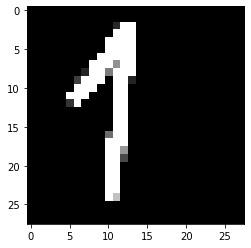

In [315]:
plot_img(one.numpy(), 1)

In [316]:
p = model.predict(one)
print(p.max())
np.argmax(p)

0.9999999


1

In [317]:
p = model2.predict(one)
print(p.max())
np.argmax(p)

1.0


1

In [318]:
model2.save('./DigitModel.h5')